# homework 5

In [2]:
import numpy as np
from scipy import integrate
from scipy import interpolate
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
# Samples for each dose level
n_samples = 5 * np.ones(4, dtype=int)
# Log-dose
dose = np.array([-.86, -.3, -.05, .73])
deaths=np.array([0, 1, 3, 5])

p_posterior is proportional to the posterior probability of alpha and beta given the observed data.  The model is that $logit(\theta)=\alpha+dose*\beta$, where theta is the probablity of death for the log drug concentration dose.

$$logit(p)=\log\left( \frac{p}{1-p} \right) =\log(p)-\log(1-p)=-\log\left( \frac{1}{p} - 1\right)$$

The $logit$ function is often used to stretch the value space of a variable that has a range from 0 to 1 (for example a probability).

As you can see below, for each dose the likelihood of the data to be observed $deaths_i$ given the probability of death $\theta_i$ and the number of tries $n_i$:

$$P( deaths_{i} \mid n_{i},\theta_{i}) \propto  \theta_{i}^{deaths_{i}}(1-\theta_{i})^{n_{i}-deaths_{i}}$$

The combined likelihood is the product of all experimental outcomes:

$$P( \{deaths_{i}\} \mid \{n_{i},\theta_{i}\}) \propto  \prod_{i}\theta_{i}^{deaths_{i}}(1-\theta_{i})^{n_{i}-deaths_{i}}$$

In order to use the function with alpha, beta being two-dimensional matrices and dose,obs_deaths and n being one-dimensional arrays, I was forced to interate over dose and then take the product over the first axis.  Let me know if there is an easier and more elegant way.

In [4]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def p_posterior(alpha,beta,dose,obs_deaths,n):
    p=[]
    for dose_i,obs_deaths_i,n_i in zip(dose,obs_deaths,n):
        theta_i=invlogit(alpha+beta*dose_i)
        p.append(theta_i**obs_deaths_i*(1-theta_i)**(n_i-obs_deaths_i))
    p=np.array(p)
    return np.prod(p,axis=0)

We also need to define a function to calculate the inverse cummulative distribution function

In [5]:
# calculate inverse cummulative distribution function for sampling
def inv_cdf(pdf,x):
    cdf_pdf=[integrate.simps(pdf[:i+1],x[:i+1]) for i in range(len(x)-1)]
    cdf_pdf=np.array([0.0]+cdf_pdf)
    cdf_pdf=cdf_pdf/cdf_pdf[-1]
    return interpolate.interp1d(cdf_pdf,x)

Now lets calculate the posterior probablity over a grid of points

In [6]:
delta = 0.1
alpha = np.arange(-5.0, 10.0+delta, delta)
beta = np.arange(-10.0, 40+delta, delta)
ALPHA, BETA = np.meshgrid(alpha, beta)
P = p_posterior(ALPHA,BETA,dose,deaths,n_samples)

(0, 25)

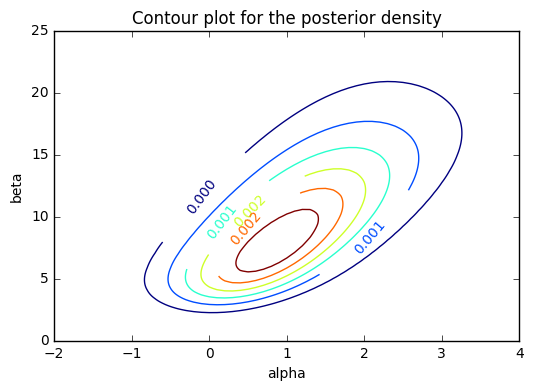

In [7]:
plt.figure()
CS = plt.contour(ALPHA, BETA, P)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour plot for the posterior density')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.xlim((-2,4))
plt.ylim((0,25))

we can now calculate the average alpha and beta distributions by averaging over the other direction

In [8]:
# average distributions
alpha_pro=np.mean(P,axis=0)
beta_pro=np.mean(P,axis=1)

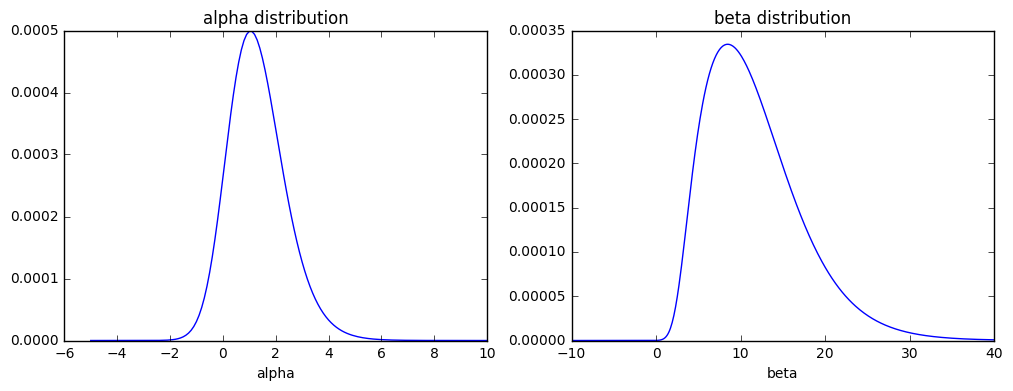

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(alpha,alpha_pro)
plt.xlabel('alpha')
plt.title('alpha distribution')
plt.subplot(1,2,2)
plt.plot(beta,beta_pro)
plt.xlabel('beta')
plt.title('beta distribution')

In this example we will employ a Gibbs sampler that we start with a random sample from the average alpha distribution.
We sampling using the inverse-cdf method that is described in Gelman's book. 

In [42]:
n = 1000
# Starting point for MCMC sampler is drawn from average alpha
alpha0 = inv_cdf(alpha_pro,alpha)(np.random.random())
beta0 = inv_cdf(p_posterior(alpha0,beta,dose,deaths,n_samples),beta)(np.random.random())
p0 = p_posterior(alpha0,beta0,dose,deaths,n_samples)

alpha_sampling = [alpha0]
beta_sampling = [beta0]

accept=0
# your implementation of MCMC should go here
steps = np.random.multivariate_normal([0,0],[[2,0],[0,2]],n)
for step in steps:
    alpha1 = alpha0 + step[0]
    beta1 = beta0 + step[1]
    p1 = p_posterior(alpha1,beta1,dose,deaths,n_samples)
    a = min(1.0,p1/p0)
    if a==1.0 or a>np.random.rand():
        alpha0=alpha1
        beta0=beta1
        p0=p1
        accept +=1
    alpha_sampling.append(alpha0)
    beta_sampling.append(beta0)
    
print("acceptance rate:",accept/n*100.0)
alpha_sampling = np.array(alpha_sampling)
beta_sampling = np.array(beta_sampling)
ld50=-alpha_sampling/beta_sampling

acceptance rate: 52.900000000000006


lets look at the calculated LD50 distribution

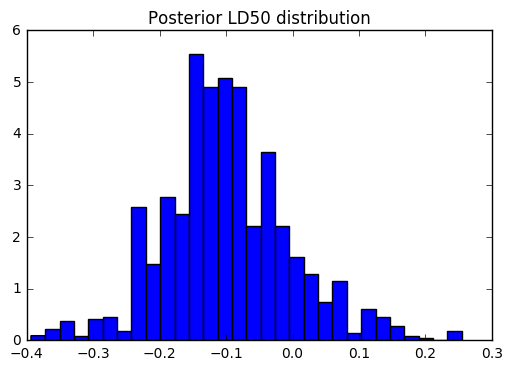

In [43]:
plt.figure()
plt.hist(ld50,bins='auto',normed=True)
plt.title('Posterior LD50 distribution')

In [44]:
print(np.percentile(ld50,[2.5,25,50,75,97.5]))

[-0.29206881 -0.15480185 -0.10641869 -0.04542101  0.11690251]


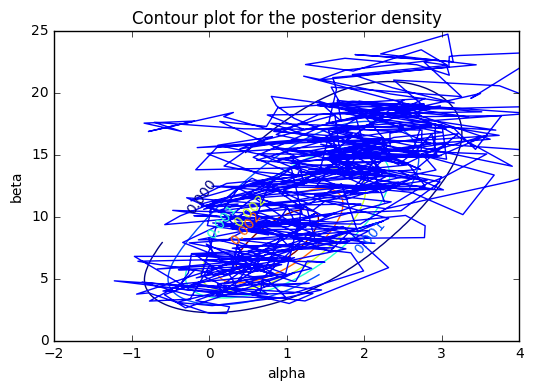

In [45]:
plt.figure()
CS = plt.contour(ALPHA, BETA, P)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour plot for the posterior density')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.xlim((-2,4))
plt.ylim((0,25))
plt.plot(alpha_sampling, beta_sampling)